✅ Using dataset: /home/sugeethjsa/Documents/GitHub/dhivyanj/qff25-hthn/weatherHistory.csv
HYBRID QUANTUM-CLASSICAL RENEWABLE ENERGY CLASSIFIER (demo)
✅ Using local dataset: /home/sugeethjsa/Documents/GitHub/dhivyanj/qff25-hthn/weatherHistory.csv
Loaded /home/sugeethjsa/Documents/GitHub/dhivyanj/qff25-hthn/weatherHistory.csv with shape (96453, 12)
Loaded 365 days; unique labels: ['Hydro' 'Solar' 'Wind']

--- DEBUG: POST-LOAD INSPECTION ---
Unique labels generated: (array(['Hydro', 'Solar', 'Wind'], dtype='<U5'), array([258,  89,  18]))
--- END DEBUG ---

Running QRC on 365 days... (this may be slow with many qubits/layers)
  Processed 50/365 days
  Processed 100/365 days
  Processed 150/365 days
  Processed 200/365 days
  Processed 250/365 days
  Processed 300/365 days
  Processed 350/365 days
Reservoir states shape: (365, 5)
Saved example GASF image as gasf_example_day1.png
Label mapping: {'Hydro': 0, 'Solar': 1, 'Wind': 2}
✅ Computed class weights: {0: 0.4715762273901809, 1: 1.3670411

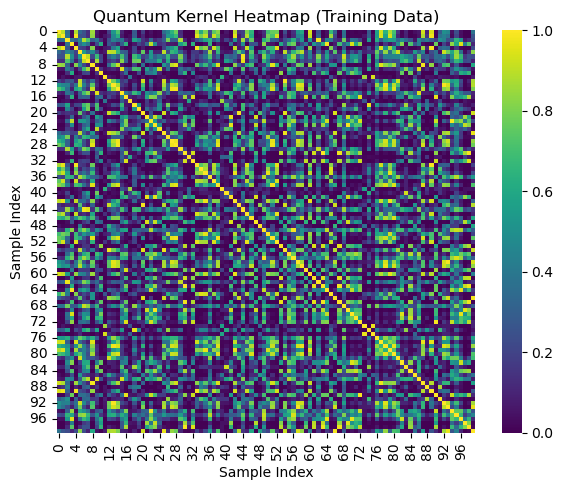

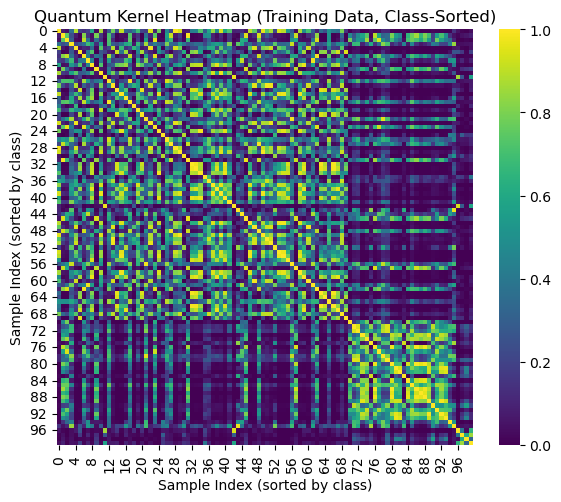

✅ Saved class-sorted quantum kernel heatmap as quantum_kernel_heatmap_sorted.png
🌀 Performing Kernel PCA for 2D visualization...


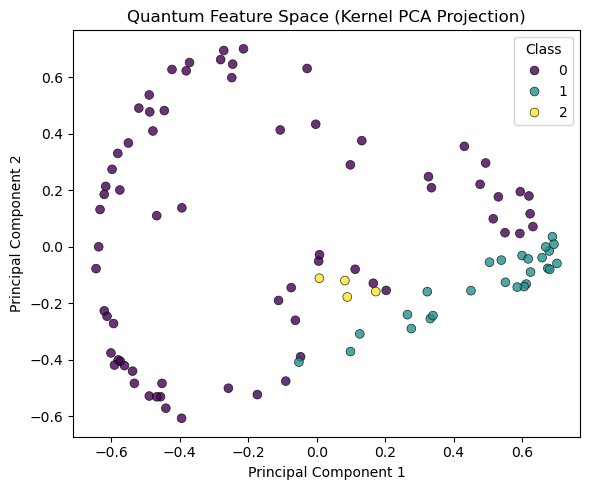

✅ Saved Kernel PCA projection as quantum_kpca_projection.png
Computing test kernel matrix...

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        51
           1       0.83      0.83      0.83        18
           2       1.00      0.50      0.67         4

    accuracy                           0.92        73
   macro avg       0.93      0.77      0.82        73
weighted avg       0.92      0.92      0.91        73

Computing kernel between full-year data and training set...

RENEWABLE ENERGY RECOMMENDATION
Primary recommendation: Hydro (score 257.40)
Saved daily_probabilities.png


In [17]:
"""
Hybrid Quantum-Classical System for Renewable Energy Source Classification

- Uses a Quantum Reservoir (QRC) for feature extraction and a quantum-inspired
  kernel (via PennyLane feature-state circuits) used with a classical SVM.
- By default uses generated mock weather data so the pipeline runs end-to-end.
- If you want to plug in a Kaggle dataset later, replace `download_kaggle_dataset`
  or provide a local CSV folder path to `load_and_preprocess_data`.

Dependencies:
    pip install numpy matplotlib scikit-learn pandas pennylane

Author: Cleaned and corrected version (beginner-fraiendly)., MinMaxScaler
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA

import pennylane as qml

# ---------------------------
# Config / Global variables
# ---------------------------
HAS_RIVER_IN_AREA = True

N_QUBITS = 5
N_QUBITS_QSVC = 4

# Quantum devices
dev_qrc = qml.device("default.qubit", wires=N_QUBITS)
dev_qsvc = qml.device("default.qubit", wires=N_QUBITS_QSVC)

# =========================
# 🌍 Central Configuration
# =========================
CONFIG = {
    # --- Feature scaling reference values ---
    "FEATURE_SCALING": {
        "Temperature (C)": 40.0,     # °C — normalized as /40
        "Wind Speed (km/h)": 50.0,   # km/h — normalized as /50
        "Humidity": 1.0,             # already 0–1
    },

    # --- Classification thresholds ---
    "DOMINANCE_THRESHOLD": 0.32,     # 90th percentile of normalized wind speeds

    # --- Labels used for renewable classification ---
    "ENERGY_LABELS": ["Solar", "Wind", "Hydro", "Geothermal", "Mixed"],

    # --- Optional logging / debug settings ---
    "DEBUG": True,                   # set False to silence logs
}

# ---------------------------
# Data loading / preprocessing
# ---------------------------

def download_kaggle_dataset():
    """
    Placeholder for Kaggle dataset download.

    - If you have the Kaggle CLI/API set up, implement this to download and
      return a local path. For now the function raises NotImplementedError
      so the main() will fallback to mock data.
    """
    raise NotImplementedError(
        "Kaggle download not implemented in this environment. "
        "Either put CSV files in a folder and pass the path to "
        "load_and_preprocess_data, or edit this function to use the Kaggle API."
    )


def load_and_preprocess_data(dataset_path=None, max_days=365):
    """
    Loads CSV files from dataset_path (if provided) and preprocesses.
    Accepts either:
      - a full path to a single CSV file, or
      - a directory containing CSV files.

    If no dataset_path or no CSVs found, it falls back to synthetic mock data.

    Returns:
        features: (n_samples, 3)
        labels: (n_samples,)
    """
    if dataset_path:
        csv_files = []

        # If the user passed a single CSV file path, handle it directly
        if os.path.isfile(dataset_path) and dataset_path.lower().endswith(".csv"):
            csv_files = [dataset_path]
        else:
            # Otherwise walk the directory tree and collect CSVs
            for root, dirs, files in os.walk(dataset_path):
                for f in files:
                    if f.lower().endswith(".csv"):
                        csv_files.append(os.path.join(root, f))

        if csv_files:
            # Load the first CSV and attempt to map columns
            df = pd.read_csv(csv_files[0])
            print(f"Loaded {csv_files[0]} with shape {df.shape}")
            return _preprocess_dataframe(df, max_days)

    # fallback
    print("No dataset available or dataset path empty — generating mock data.")
    return generate_mock_data(days=max_days)

'''
def _preprocess_dataframe(df, max_days=365):
    # identify possible columns for features
    n_samples = len(df)
    features_dict = {'solar_irradiance': None, 'wind_speed': None, 'water_flow': None}

    # --- UPDATED CANDIDATES ---
    temp_candidates = ['Temperature_C', 'temperature', 'Temperature', 'temp_C', 'temp', 'Temperature (C)']
    wind_candidates = ['Wind_Speed_kmh', 'wind_speed', 'Wind Speed_km/h', 'wind_kmph', 'wind_kmh', 'Wind Speed (km/h)']
    # --- END UPDATES ---

    # Solar irradiance
    for c in temp_candidates:
        if c in df.columns:
            features_dict['solar_irradiance'] = df[c].astype(float)
            break

    # Wind speed candidates
    for c in wind_candidates:
        if c in df.columns:
            features_dict['wind_speed'] = df[c].astype(float)
            break

    # Water flow approximated from humidity or precipitation
    if 'Humidity' in df.columns:
        features_dict['water_flow'] = df['Humidity'].astype(float)
    elif 'humidity' in df.columns:
        features_dict['water_flow'] = df['humidity'].astype(float)
    elif 'Precipitation' in df.columns:
        features_dict['water_flow'] = np.tanh(df['Precipitation'].astype(float) / 10.0)

    # fill missing feature columns with random values
    for k in features_dict:
        if features_dict[k] is None:
            print(f"Warning: could not find column for {k}, generating synthetic values")
            features_dict[k] = np.random.rand(n_samples)
        else:
            features_dict[k] = np.asarray(features_dict[k])

    # --- ROBUST SCALING (REPLACES OLD METHOD) ---
    features_unscaled = np.column_stack([
        features_dict['solar_irradiance'],
        features_dict['wind_speed'],
        features_dict['water_flow']
    ])

    # Scale each feature (column) independently to [0, 1]
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features_unscaled)
    # --- END ROBUST SCALING ---

    # trim or pad to max_days
    if len(features) > max_days:
     features = features[:max_days]

    # Now generate labels based on correctly scaled data
    labels = np.array([get_label(f) for f in features])

    return features, labels
'''
def auto_update_threshold(features, config=CONFIG):
    """
    Dynamically updates CONFIG['DOMINANCE_THRESHOLD'] based on dataset statistics.
    Currently uses 90th percentile of normalized wind speeds as baseline.
    """
    solar_irr = features[:, 0]
    wind_spd = features[:, 1]
    water_flw = features[:, 2]

    # Compute percentiles for insight
    wind_90 = np.percentile(wind_spd, 90)
    solar_90 = np.percentile(solar_irr, 90)
    water_90 = np.percentile(water_flw, 90)

    # Option 1: Use the 90th percentile of wind as base threshold
    dominance_threshold = np.mean([wind_90, solar_90, water_90]) * 0.8  # make it a bit lenient

    config["DOMINANCE_THRESHOLD"] = float(dominance_threshold)

    if config["DEBUG"]:
        print("\n--- AUTO THRESHOLD UPDATE ---")
        print(f"90th percentile wind speed: {wind_90:.3f}")
        print(f"90th percentile solar irradiance: {solar_90:.3f}")
        print(f"90th percentile water flow: {water_90:.3f}")
        print(f"→ Adaptive dominance threshold set to {dominance_threshold:.3f}")
        print("------------------------------\n")

    return config
'''
def _preprocess_dataframe(df, config=CONFIG):
    """
    Normalize key weather features and derive renewable dominance labels.
    """

    scale = config["FEATURE_SCALING"]
    thres = config["DOMINANCE_THRESHOLD"]

    # Extract & normalize
    solar = df["Temperature (C)"] / scale["Temperature (C)"]
    wind = df["Wind Speed (km/h)"] / scale["Wind Speed (km/h)"]
    water = df["Humidity"] / scale["Humidity"]

    features = np.vstack([solar, wind, water]).T

    # Apply dominance-based labeling
    def get_label(x):
        solar_irr, wind_spd, water_flw = x
        max_feature = max(x)

        if solar_irr == max_feature and solar_irr > thres:
            return "Solar"
        elif wind_spd == max_feature and wind_spd > thres:
            return "Wind"
        elif water_flw == max_feature and water_flw > thres:
            return "Hydro"
        elif all(v < 0.3 for v in x):
            return "Geothermal"
        else:
            return "Mixed"

    df["DominantEnergy"] = [get_label(x) for x in features]

    if config["DEBUG"]:
        print(f"[INFO] Using dominance threshold: {thres}")
        print(df["DominantEnergy"].value_counts())

    return features, df["DominantEnergy"]
'''
def generate_mock_data(days=365):
    """
    Generate synthetic seasonal-looking data for testing.
    """
    t = np.linspace(0, 2 * np.pi, days)

    solar_irradiance = 0.5 + 0.3 * np.sin(t) + 0.2 * np.random.rand(days)
    wind_speed = 0.5 - 0.2 * np.sin(t) + 0.3 * np.random.rand(days)
    water_flow = 0.4 + 0.25 * np.sin(t + np.pi / 4) + 0.35 * np.random.rand(days)

    solar_irradiance = np.clip(solar_irradiance, 0, 1)
    wind_speed = np.clip(wind_speed, 0, 1)
    water_flow = np.clip(water_flow, 0, 1)

    features = np.column_stack([solar_irradiance, wind_speed, water_flow])
    labels = np.array([get_label(f) for f in features])
    return features, labels

# Centralized feature config (can be imported or tuned easily)
FEATURE_THRESHOLDS = {
    "solar_irradiance": 0.35,   # Top ~10-15% of temperature range
    "wind_speed": 0.20,         # Top 10% of wind range
    "water_flow": 0.40         # Top ~15% of humidity range
}

def _preprocess_dataframe(df, max_days=365):
    n_samples = len(df)
    features_dict = {'solar_irradiance': None, 'wind_speed': None, 'water_flow': None}

    # --- UPDATED CANDIDATES ---
    temp_candidates = ['Temperature_C', 'temperature', 'Temperature', 'temp_C', 'temp', 'Temperature (C)']
    wind_candidates = ['Wind_Speed_kmh', 'wind_speed', 'Wind Speed_km/h', 'wind_kmph', 'wind_kmh', 'Wind Speed (km/h)']
    # --- END UPDATES ---

    # Extract solar irradiance (temperature proxy)
    for c in temp_candidates:
        if c in df.columns:
            features_dict['solar_irradiance'] = df[c].astype(float)
            break

    # Extract wind speed
    for c in wind_candidates:
        if c in df.columns:
            features_dict['wind_speed'] = df[c].astype(float)
            break

    # Water flow (humidity or precipitation)
    if 'Humidity' in df.columns:
        features_dict['water_flow'] = df['Humidity'].astype(float)
    elif 'humidity' in df.columns:
        features_dict['water_flow'] = df['humidity'].astype(float)
    elif 'Precipitation' in df.columns:
        features_dict['water_flow'] = np.tanh(df['Precipitation'].astype(float) / 10.0)

    # Fill missing feature columns with random values
    for k in features_dict:
        if features_dict[k] is None:
            print(f"Warning: could not find column for {k}, generating synthetic values")
            features_dict[k] = np.random.rand(n_samples)
        else:
            features_dict[k] = np.asarray(features_dict[k])

    # --- SCALING ---
    features_unscaled = np.column_stack([
        features_dict['solar_irradiance'],
        features_dict['wind_speed'],
        features_dict['water_flow']
    ])
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features_unscaled)
    # --- END SCALING ---

    # Trim or pad to max_days
    if len(features) > max_days:
        features = features[:max_days]

    # --- UPDATED LABEL LOGIC ---
    def get_label(f):
        solar, wind, water = f
        scores = {
            "Solar": solar / FEATURE_THRESHOLDS["solar_irradiance"],
            "Wind": wind / FEATURE_THRESHOLDS["wind_speed"],
            "Hydro": water / FEATURE_THRESHOLDS["water_flow"]
        }

        # Pick the feature that exceeds its threshold the most
        dominant = max(scores, key=scores.get)

        # Only count as valid if it crosses at least 1.0× its threshold
        if scores[dominant] < 1.0:
            return "Mixed"
        return dominant

    labels = np.array([get_label(f) for f in features])
    # --- END LABEL LOGIC ---

    return features, labels


def get_label(features):
    """
    Map feature triple to a label string.
    Uses the global HAS_RIVER_IN_AREA to consider Hydro feasibility.
    """
    solar_irr, wind_spd, water_flw = features
    DOMINANCE_THRESHOLD = 0.4
    max_feature = max(solar_irr, wind_spd, water_flw)

    if solar_irr == max_feature and solar_irr > DOMINANCE_THRESHOLD:
        return "Solar"
    elif wind_spd == max_feature and wind_spd > DOMINANCE_THRESHOLD:
        return "Wind"
    elif water_flw == max_feature and water_flw > DOMINANCE_THRESHOLD:
        if HAS_RIVER_IN_AREA:
            return "Hydro"
        else:
            return "Solar" if solar_irr > wind_spd else "Wind"
    elif solar_irr < 0.3 and wind_spd < 0.3 and water_flw < 0.3:
        return "Geothermal"
    else:
        return "Mixed"


# ---------------------------
# Quantum Reservoir Computer
# ---------------------------

def encode_input(features, n_qubits):
    """
    Expand 3 features to n_qubits rotation angles (0..2pi)
    """
    encoded = np.zeros(n_qubits)
    for i in range(n_qubits):
        encoded[i] = features[i % len(features)]
    return encoded * 2 * np.pi


@qml.qnode(dev_qrc)
def qrc_circuit(params, weights):
    """
    QRC circuit: encode with RY and apply StronglyEntanglingLayers.
    Returns expectation values <Z> per qubit.
    """
    # input rotations
    for i in range(N_QUBITS):
        qml.RY(float(params[i]), wires=i)

    # Strongly entangling layers expect shape (n_layers, n_wires, 3)
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))

    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]


def run_qrc(daily_features_list, n_layers=2):
    """
    Run QRC across the sequence to get reservoir states.
    """
    n_days = len(daily_features_list)
    # small random init for StronglyEntanglingWeights
    # shape: (n_layers, n_wires, 3)
    weights = 0.1 * np.random.randn(n_layers, N_QUBITS, 3)

    reservoir_state = np.zeros(N_QUBITS)
    reservoir_states = []

    print(f"Running QRC on {n_days} days... (this may be slow with many qubits/layers)")
    for idx, features in enumerate(daily_features_list):
        encoded = encode_input(features, N_QUBITS)
        combined = encoded + 0.5 * reservoir_state
        new_state = qrc_circuit(combined, weights)
        reservoir_state = np.array(new_state, dtype=float)
        reservoir_states.append(reservoir_state.copy())

        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1}/{n_days} days")

    return np.array(reservoir_states)


# ---------------------------
# GASF conversion
# ---------------------------

def vector_to_image(vector):
    """
    Gramian Angular Summation Field for a 1D vector of length N -> NxN image
    """
    v = np.array(vector, dtype=float)
    minv, maxv = v.min(), v.max()
    if np.isclose(maxv - minv, 0.0):
        v_scaled = np.zeros_like(v)
    else:
        v_scaled = 2 * (v - minv) / (maxv - minv) - 1.0
    v_scaled = np.clip(v_scaled, -1.0, 1.0)
    angles = np.arccos(v_scaled)
    n = len(angles)
    gasf = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            gasf[i, j] = np.cos(angles[i] + angles[j])
    return gasf


def visualize_gasf_image(gasf_image, title="GASF_Image"):
    plt.figure(figsize=(4, 4))
    plt.imshow(gasf_image, cmap="viridis", interpolation="nearest")
    plt.colorbar()
    plt.title(title)
    fname = f"gasf_{title.replace(' ', '_')}.png"
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()
    print(f"Saved example GASF image as {fname}")


# ---------------------------
# Quantum feature map & kernel (QSVC)
# ---------------------------

@qml.qnode(dev_qsvc)
def feature_state_circuit(features):
    """
    Embed classical features (length <= N_QUBITS_QSVC) into a quantum state and return statevector.
    """
    # ensure length exactly N_QUBITS_QSVC
    features = np.asarray(features, dtype=float)
    if len(features) < N_QUBITS_QSVC:
        padded = np.zeros(N_QUBITS_QSVC)
        padded[:len(features)] = features
        features = padded
    else:
        features = features[:N_QUBITS_QSVC]

    qml.AngleEmbedding(features, wires=range(N_QUBITS_QSVC))

    # simple entangling chain
    for i in range(N_QUBITS_QSVC - 1):
        qml.CNOT(wires=[i, i + 1])

    return qml.state()


def compute_kernel_matrix(X1, X2):
    """
    Compute kernel matrix K where K[i,j] = |<psi(x_i) | psi(x_j)>|^2
    using feature_state_circuit to produce statevectors.

    This is expensive but okay for small datasets/demo.
    """
    n1 = len(X1)
    n2 = len(X2)
    K = np.zeros((n1, n2), dtype=float)

    # Precompute statevectors
    states1 = [np.asarray(feature_state_circuit(x)) for x in X1]
    states2 = [np.asarray(feature_state_circuit(x)) for x in X2]

    for i in range(n1):
        for j in range(n2):
            overlap = np.vdot(states1[i], states2[j])
            K[i, j] = np.abs(overlap) ** 2
    return K


def prepare_qsvc_data(reservoir_states, labels):
    """
    Convert reservoir states -> GASF -> flatten -> PCA reduce to N_QUBITS_QSVC dims
    and encode labels.
    """
    gasf_images = [vector_to_image(s) for s in reservoir_states]
    if len(gasf_images) > 0:
        visualize_gasf_image(gasf_images[0], title="example_day1")

    X_flat = np.array([img.flatten() for img in gasf_images])
    n_features_target = min(N_QUBITS_QSVC, X_flat.shape[1])
    pca = PCA(n_components=n_features_target)
    X_reduced = pca.fit_transform(X_flat)

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    print(f"Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

    return X_reduced, y_encoded, label_encoder, pca


def train_qsvc(X_train, X_test, y_train, y_test, max_train_samples=100):
    """
    Compute quantum kernel matrices and train classical SVM with precomputed kernel.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import classification_report
    from sklearn.svm import SVC
    import numpy as np

    print(f"Training QSVC: {len(X_train)} train samples, {len(X_test)} test samples")

    # optionally limit training size for speed
    if len(X_train) > max_train_samples:
        idx = np.random.choice(len(X_train), max_train_samples, replace=False)
        X_train_used = X_train[idx]
        y_train_used = y_train[idx]
    else:
        X_train_used = X_train
        y_train_used = y_train

    print("Computing training kernel matrix (may take time)...")
    K_train = compute_kernel_matrix(X_train_used, X_train_used)

    # --- 🔥 Visualize Quantum Kernel Heatmap ---
    plt.figure(figsize=(6, 5))
    sns.heatmap(K_train, cmap="viridis")
    plt.title("Quantum Kernel Heatmap (Training Data)")
    plt.xlabel("Sample Index")
    plt.ylabel("Sample Index")
    plt.tight_layout()
    plt.show()
    # --- End Visualization ---

    # Order samples by class labels for structured visualization
    order = np.argsort(y_train_used)
    K_sorted = K_train[order][:, order]

    plt.figure(figsize=(6, 5))
    sns.heatmap(K_sorted, cmap="viridis", square=True, cbar=True, vmin=0, vmax=1)
    plt.title("Quantum Kernel Heatmap (Training Data, Class-Sorted)")
    plt.xlabel("Sample Index (sorted by class)")
    plt.ylabel("Sample Index (sorted by class)")
    plt.tight_layout()
    plt.savefig("quantum_kernel_heatmap_sorted.png", dpi=300)
    plt.show()

    print("✅ Saved class-sorted quantum kernel heatmap as quantum_kernel_heatmap_sorted.png")
    # --- End Heatmap ---

    # --- Quantum Kernel PCA Visualization ---
    from sklearn.decomposition import KernelPCA

    print("🌀 Performing Kernel PCA for 2D visualization...")
    kpca = KernelPCA(n_components=2, kernel="precomputed")
    X_kpca = kpca.fit_transform(K_train)

    # Sort again for consistent coloring
    order = np.argsort(y_train_used)
    X_kpca_sorted = X_kpca[order]
    y_sorted = np.array(y_train_used)[order]

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=X_kpca_sorted[:, 0], 
        y=X_kpca_sorted[:, 1],
        hue=y_sorted,
        palette="viridis",
        s=40,
        alpha=0.8,
        edgecolor="black"
    )
    plt.title("Quantum Feature Space (Kernel PCA Projection)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Class", loc="best")
    plt.tight_layout()
    plt.savefig("quantum_kpca_projection.png", dpi=300)
    plt.show()

    print("✅ Saved Kernel PCA projection as quantum_kpca_projection.png")
    # --- End Quantum PCA ---


    svc = SVC(kernel="precomputed", probability=True, random_state=42)
    svc.fit(K_train, y_train_used)

    print("Computing test kernel matrix...")
    K_test = compute_kernel_matrix(X_test, X_train_used)

    predictions = svc.predict(K_test)
    probabilities = svc.predict_proba(K_test)

    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    return svc, K_train, predictions, probabilities, X_train_used


# ---------------------------
# Analysis & visualization
# ---------------------------

def analyze_full_year(features, reservoir_states, svc, X_train_used, label_encoder, pca):
    """
    Compute predictions for all days and summarize annual suitability.
    """
    n_days = len(features)
    gasf_images = [vector_to_image(s) for s in reservoir_states]
    X_full_flat = np.array([img.flatten() for img in gasf_images])
    X_full_reduced = pca.transform(X_full_flat)

    print("Computing kernel between full-year data and training set...")
    K_full = compute_kernel_matrix(X_full_reduced, X_train_used)

    daily_probs = svc.predict_proba(K_full)
    daily_pred = svc.predict(K_full)
    classes = label_encoder.classes_

    total_scores = {c: daily_probs[:, i].sum() for i, c in enumerate(classes)}

    # find best 30-day windows
    window_size = min(30, n_days)
    best_windows = {}
    for i, c in enumerate(classes):
        probs = daily_probs[:, i]
        best_avg = -1
        best_start = 0
        for start in range(0, n_days - window_size + 1):
            avg = probs[start:start + window_size].mean()
            if avg > best_avg:
                best_avg = avg
                best_start = start
        best_windows[c] = {'start_day': int(best_start), 'avg_score': float(best_avg)}

    sorted_types = sorted(total_scores.items(), key=lambda x: x[1], reverse=True)
    primary_type, primary_score = sorted_types[0]

    recommendation = {
        'primary_type': primary_type,
        'primary_score': float(primary_score),
        'all_scores': total_scores,
        'best_windows': best_windows,
        'daily_probabilities': daily_probs,
        'daily_predictions': daily_pred,
        'classes': classes
    }

    # secondary if within 90%
    if len(sorted_types) > 1:
        sec_type, sec_score = sorted_types[1]
        if sec_score >= 0.9 * primary_score:
            recommendation['secondary_type'] = sec_type
            recommendation['secondary_score'] = float(sec_score)

    return recommendation


def print_final_recommendation(recommendation):
    print("\n" + "=" * 50)
    print("RENEWABLE ENERGY RECOMMENDATION")
    print("=" * 50)
    print(f"Primary recommendation: {recommendation['primary_type']} (score {recommendation['primary_score']:.2f})")
    if 'secondary_type' in recommendation:
        print(f"Secondary: {recommendation['secondary_type']} (score {recommendation['secondary_score']:.2f})")
    print("=" * 50)


def visualize_annual_trends(recommendation):
    daily_probs = recommendation['daily_probabilities']
    classes = recommendation['classes']
    n_days = daily_probs.shape[0]

    plt.figure(figsize=(12, 6))
    days = np.arange(n_days)
    for i, c in enumerate(classes):
        plt.plot(days, daily_probs[:, i], label=c)
    plt.xlabel("Day")
    plt.ylabel("Probability")
    plt.legend()
    plt.title("Daily probabilities")
    plt.tight_layout()
    plt.savefig("daily_probabilities.png", dpi=150)
    plt.close()
    print("Saved daily_probabilities.png")


# ---------------------------
# Main
# ---------------------------

def main(use_kaggle=False, kaggle_path=None):
    np.random.seed(42)

    print("HYBRID QUANTUM-CLASSICAL RENEWABLE ENERGY CLASSIFIER (demo)")

    # Load data
    try:
        if use_kaggle:
            print("📦 Using Kaggle dataset...")
            dataset_path = download_kaggle_dataset()
            features, labels = load_and_preprocess_data(dataset_path)
        elif kaggle_path and os.path.exists(kaggle_path):
            print(f"✅ Using local dataset: {kaggle_path}")
            features, labels = load_and_preprocess_data(kaggle_path)
        else:
            print("⚠️ No dataset available or invalid path — generating mock data.")
            features, labels = generate_mock_data(days=365)
    except Exception as e:
        print(f"⚠️ Dataset load failed — generating mock data instead. Reason: {e}")
        features, labels = generate_mock_data(days=365)

    print(f"Loaded {len(features)} days; unique labels: {np.unique(labels)}")

    # ADD THESE LINES
    print("\n--- DEBUG: POST-LOAD INSPECTION ---")
    print(f"Unique labels generated: {np.unique(labels, return_counts=True)}")
    print("--- END DEBUG ---\n")

    # QRC
    reservoir_states = run_qrc(features, n_layers=2)
    print(f"Reservoir states shape: {reservoir_states.shape}")

    # Prepare QSVC data
    X_reduced, y_encoded, label_encoder, pca = prepare_qsvc_data(reservoir_states, labels)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # ==================================================
    # AUTO-BALANCING & KERNEL VISUALIZATION BLOCK
    # ==================================================
    

    # --- 1️⃣ Normalize features ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(reservoir_states)

    # --- 2️⃣ Encode labels numerically ---
    label_mapping = {'Hydro': 0, 'Solar': 1, 'Wind': 2}
    y_encoded = np.array([label_mapping[y] for y in labels])

    # --- 3️⃣ Compute and display class weights ---
    classes = np.unique(y_encoded)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
    class_weights = dict(zip(classes, weights))
    print("✅ Computed class weights:", class_weights)

    # --- 4️⃣ Split dataset with stratification (preserves class ratios) ---
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )


    svc, K_train, preds, probs, X_train_used = train_qsvc(X_train, X_test, y_train, y_test)

    recommendation = analyze_full_year(features, reservoir_states, svc, X_train_used, label_encoder, pca)

    print_final_recommendation(recommendation)
    visualize_annual_trends(recommendation)

    return recommendation


if __name__ == "__main__":
    csv_path = os.path.join(os.getcwd(), "weatherHistory.csv")

    if not os.path.exists(csv_path):
        print("❌ File not found:", csv_path)
    else:
        print("✅ Using dataset:", csv_path)

    recommendation = main(use_kaggle=False, kaggle_path=csv_path)

